In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [ ]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [ ]:
def shuffle(trainData, trainTarget):
    np.random.seed(103)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target

In [ ]:
def ReLU(x):
    reluoutput = np.maximum(x, 0)
    return reluoutput

In [ ]:
def softmax(x):
    softmaxoutput = np.exp(x - np.max(x, keepdims=True)) / np.sum(np.exp(x - np.max(x, keepdims=True)), axis=0, keepdims=True)
    return softmaxoutput

In [ ]:
def compute(x, W, b):
    W = np.transpose(W)
    return np.transpose((np.transpose(np.matmul(W, x)) + b))

In [ ]:
def averageCE(target, pred):
    CEoutput = -np.mean(np.sum((target * np.transpose(np.log(pred))), axis=1 ))
    return CEoutput

In [ ]:
def gradCE(target, o):
    pred = softmax(o)
    gradCEoutput = pred - np.transpose(target)
    return gradCEoutput

In [ ]:
def flatten(Data, N):
    return np.reshape(Data, (784, N))

In [ ]:
class NN():
    def __init__(self, sizes, epochs=200, alpha=0.1):
        self.sizes = sizes
        self.epochs = epochs
        self.alpha = alpha
        self.input_parameters, self.hidden_parameters, self.output_parameters = self.initialization()

    def initialization(self):
        F = self.sizes[0]
        H = self.sizes[1]
        K = self.sizes[2]
        input_parameters = {}
        W_h = np.random.randn(F,H) * np.sqrt( 2.0 / (F + H) )
        b_h = np.zeros(H)
        hidden_parameters = {
            'W_h': W_h,
            'b_h': b_h
        }
        W_o = np.random.randn(H,K) * np.sqrt( 2.0 / (H + K) )
        b_o = np.zeros(K)
        output_parameters = {
            'W_o': W_o,
            'b_o': b_o
        }
        return input_parameters, hidden_parameters, output_parameters

    def forwardPass(self, data):
        input_parameters = self.input_parameters
        hidden_parameters = self.hidden_parameters
        output_parameters = self.output_parameters
        
        input_parameters['x'] = data
        
        hidden_parameters['s'] = compute(input_parameters['x'], hidden_parameters['W_h'], hidden_parameters['b_h'])
        hidden_parameters['h'] = ReLU(hidden_parameters['s'])

        output_parameters['o'] = compute(hidden_parameters['h'], output_parameters['W_o'], output_parameters['b_o'])
        output_parameters['p'] = softmax(output_parameters['o'])
        return output_parameters['p']

    def backwardPass(self, target):
        input_parameters = self.input_parameters
        hidden_parameters = self.hidden_parameters
        output_parameters = self.output_parameters

        change_hidden_parameters = {}
        change_output_parameters = {}
        N = target.shape[0]
        K = target.shape[1]

        sensitivity_W_o = gradCE(target, output_parameters['o'])
        change_output_parameters['W_o'] = np.matmul(hidden_parameters['h'], np.transpose(sensitivity_W_o)) / N
        change_output_parameters['b_o'] = np.mean(sensitivity_W_o, axis=1)

        hidden_parameters['s'] = np.where( hidden_parameters['s']<0, 0, hidden_parameters['s'] )
        hidden_parameters['s'] = np.where( hidden_parameters['s']>0, 1, hidden_parameters['s'] )

        sensitivity_W_h = np.matmul(output_parameters['W_o'], sensitivity_W_o) * hidden_parameters['s'] / K
        change_hidden_parameters['W_h'] = np.matmul( input_parameters['x'], np.transpose(sensitivity_W_h) ) / N
        change_hidden_parameters['b_h'] = np.mean( sensitivity_W_h, axis=1 )

        return change_hidden_parameters, change_output_parameters

    def loss_accuracy(self, data, labels):
        output = self.forwardPass(data)
        loss = averageCE(labels, output)
        predict = np.argmax(output, axis=0)
        target = np.argmax(labels, axis=1)
        accuracy = np.mean(predict == target)

        return loss, accuracy
    
    def train(self, trainData, newtrain, validData, newvalid, testData, newtest, gamma):

        num_input = self.sizes[0] # number of input units
        num_hidden = self.sizes[1] # number of hidden units
        num_class = self.sizes[2] # number of classes

        train_losses = np.zeros(self.epochs)
        train_accuracies = np.zeros(self.epochs)
        valid_losses = np.zeros(self.epochs)
        valid_accuracies = np.zeros(self.epochs)

        momentum_W_h = np.full([num_input,num_hidden], np.power(10.0,-5))
        momentum_b_h = np.full(num_hidden, np.power(10.0,-5))
        momentum_W_o = np.full([num_hidden,num_class], np.power(10.0,-5))
        momentum_b_o = np.full(num_class, np.power(10.0,-5))

        for iteration in range(self.epochs):
            output = self.forwardPass(trainData)
            change_hidden_parameters, change_output_parameters = self.backwardPass(newtrain)

            for key, value in change_hidden_parameters.items():
                if (key == 'W_h'):
                    momentum_W_h = (gamma * momentum_W_h) + (self.alpha * value)
                    self.hidden_parameters[key] -= momentum_W_h
                elif (key == 'b_h'):
                    momentum_b_h = (gamma * momentum_b_h) + (self.alpha * value)
                    self.hidden_parameters[key] -= momentum_b_h

            for key, value in change_output_parameters.items():
                if (key == 'W_o'):
                    momentum_W_o = (gamma * momentum_W_o) + (self.alpha * value)
                    self.output_parameters[key] -= momentum_W_o
                elif (key == 'b_o'):
                    momentum_b_o = (gamma * momentum_b_o) + (self.alpha * value)
                    self.output_parameters[key] -= momentum_b_o

            train_loss, train_accuracy = self.loss_accuracy(trainData, newtrain)
            valid_loss, valid_accuracy = self.loss_accuracy(validData, newvalid)
            train_losses[iteration] = train_loss
            train_accuracies[iteration] = train_accuracy
            valid_losses[iteration] = valid_loss
            valid_accuracies[iteration] = valid_accuracy

            if (iteration%10 == 0):
                print(("Epoch {}: Train loss: {}, Train accuracy: {} |"+"Validation loss: {}, Validation accuracy: {}").format(
                    iteration + 1,
                    train_losses[iteration],
                    train_accuracies[iteration],
                    valid_losses[iteration],
                    valid_accuracies[iteration])
                )
            
        print('Training complete')

        plt.title("Train vs Validation Error")
        plt.plot(range(1,self.epochs+1), train_accuracies, label="Train")
        plt.plot(range(1,self.epochs+1), valid_accuracies, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='best')
        plt.show()
        plt.title("Train vs Validation Loss")
        plt.plot(range(1,self.epochs+1), train_losses, label="Train")
        plt.plot(range(1,self.epochs+1), valid_losses, label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(loc='best')
        plt.show()
        test_loss, test_accuracy = self.loss_accuracy(testData, newtest)
        print("Test Loss: ", test_loss)
        print("Test Accuracy: ", test_accuracy)


In [ ]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

In [ ]:
trainData = flatten(trainData, 10000)
validData = flatten(validData, 6000)
testData = flatten(testData, 2724)

In [ ]:
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

Epoch 1: Train loss: 2.4074487051106304, Train accuracy: 0.106 |Validation loss: 2.4326913738095435, Validation accuracy: 0.09283333333333334
Epoch 11: Train loss: 2.312528379697044, Train accuracy: 0.1225 |Validation loss: 2.3681855879069307, Validation accuracy: 0.09333333333333334
Epoch 21: Train loss: 2.2581313158008385, Train accuracy: 0.1563 |Validation loss: 2.3591938865310107, Validation accuracy: 0.09266666666666666
Epoch 31: Train loss: 2.2225919759990136, Train accuracy: 0.1834 |Validation loss: 2.361584966414392, Validation accuracy: 0.09483333333333334
Epoch 41: Train loss: 2.1901069613123485, Train accuracy: 0.2063 |Validation loss: 2.36310903574323, Validation accuracy: 0.09883333333333333
Epoch 51: Train loss: 2.1616313835967325, Train accuracy: 0.2255 |Validation loss: 2.3719727460103512, Validation accuracy: 0.0945
Epoch 61: Train loss: 2.1382433138963304, Train accuracy: 0.2405 |Validation loss: 2.382023242613742, Validation accuracy: 0.0955
Epoch 71: Train loss: 2.1

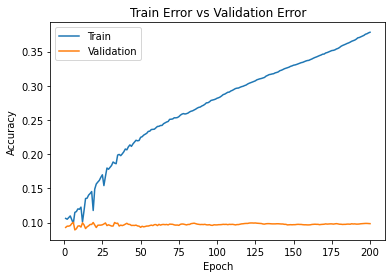

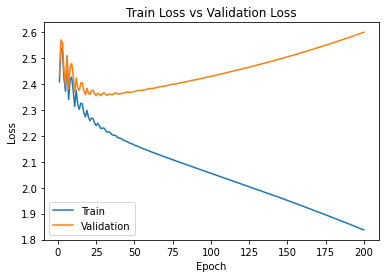

Test Loss:  2.6273302450967027
Test Accuracy:  0.09618208516886931


In [ ]:
nn = NN(sizes=[784, 1000, 10])
nn.train(trainData, newtrain, validData, newvalid, testData, newtest, 0.9)